# Egocentric coding

We want to explore the hypothesis that some neurons encode for the direction of the home base relative to the heading direction.

We will start with a more generic hypothesis that a neuron might encode an egocentric bearing angle to any point near the environment explored by the animal.

Note that as the reference point moves away from the environment explored by the animal, egocentric bearing becomes indistinguisable from allocentric head direction coding. For this reason, we will restrict our analysis to reference points near the environment explored by the animal.

<div>
<img src="../images/egocentric_bearing_angle.png" width="300"/>
</div>


The aims for this notebook are:

1. simulate an egocentric bearing neuron.
2. estimate the reference point using the position data and spike train.



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import poisson, norm, vonmises
from scipy.special import factorial
import animal_trajectory

plt.rcParams["figure.figsize"] = (25, 5)

Path of the animal

Rec time:700 sec
dt:0.02 sec
samples:35000


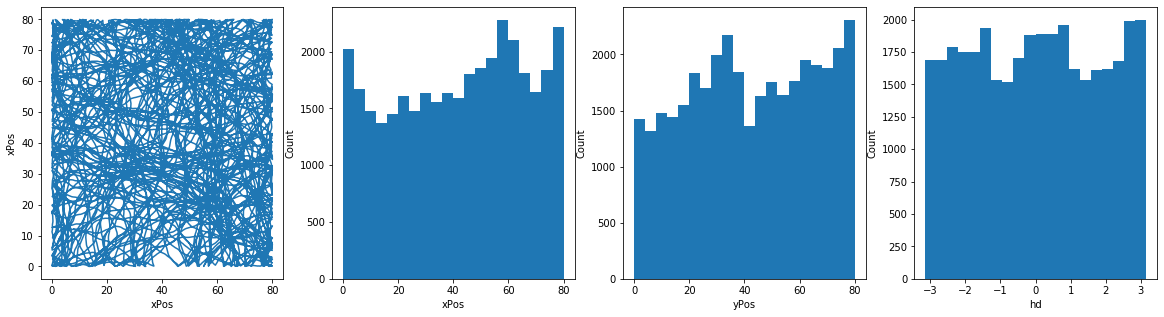

In [5]:
boxSize=80
samplingRate = 50
recordingTimeSec=700
samples=recordingTimeSec*samplingRate
dt = 1/samplingRate
stepSizeRatio = 25/samplingRate # to give it a speed of 25 cm per sec

print("Rec time:{} sec".format(recordingTimeSec))
print("dt:{} sec".format(dt))
print("samples:{}".format(samples))

position_x,position_y,head_direction = animal_trajectory.walk(samples,boxSize,stepSizeRatio)
animal_trajectory.plotPath(position_x,position_y,head_direction)
time = np.linspace(0,recordingTimeSec,samples)


## Calculate the egocentric bearing angle

Set a reference point.

Calculate the ego bearing angle

In [80]:
def egocentric_direction_to_reference_point(animal_position, animal_hd, reference_point):
    """
    Function to calculate the egocentric direction of a reference point relative the the head direction of the animal.
    
    Angle between 2 vectors:
    1) A vector from the animal head pointing in it head direction 
    2) A vector from the animals head pointing towards a reference point
    
    This tells you in which direction the reference point was relative to the antero-posterior axis of the animal head.
    
    Arguments:
    animal_poisition: 1D np.array of size 2 with x and y position of the animal
    animal_hd: head direction of the animal in radians (0 is the positive x-axis, pi is positive y-axis, -pi is negative y-axis)
    reference_point: 1D np.array of size 2 with the x and y position of the reference point
    
    Returns:
    Egocentric angle in radian of the reference point relative to a vector pointing in front of the animal's head. 
        0: in front of the animal, -pi: to the left, pi: to the right, 2*pi : to the back
    """
    
    refVector= reference_point- animal_position # vector from animal to the reference point
    
    ## we can rotate our refVectors so that the hd = 0, using a rotation matrix for 2D vector
    rotM = np.array([[np.cos(animal_hd),-np.sin(animal_hd)],[np.sin(animal_hd),np.cos(animal_hd)]])
    rotRefVector = refVector@rotM # rotate the refVector
    
    ## then the arctan2 of our rotHomeBaseUnitVector is our egocentric homing vector
    ego_angle = - np.arctan2(rotRefVector[1],rotRefVector[0]) # - is there to get same angle as Head direction if ref point is far away
    return ego_angle


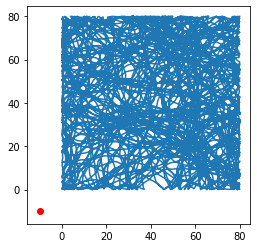

In [95]:
plt.figure(figsize=(4,4))
refPoint = np.array([-10,-10])
plt.plot(position_x,position_y)
plt.scatter(refPoint[0],refPoint[1],c="red")

In [96]:
%%time
ego = np.empty(samples)
for i in range(samples):
    ego[i] = egocentric_direction_to_reference_point(animal_position = np.array([position_x[i],position_y[i]]), 
                                            animal_hd = head_direction[i], reference_point = refPoint)

CPU times: user 486 ms, sys: 103 ms, total: 589 ms
Wall time: 468 ms


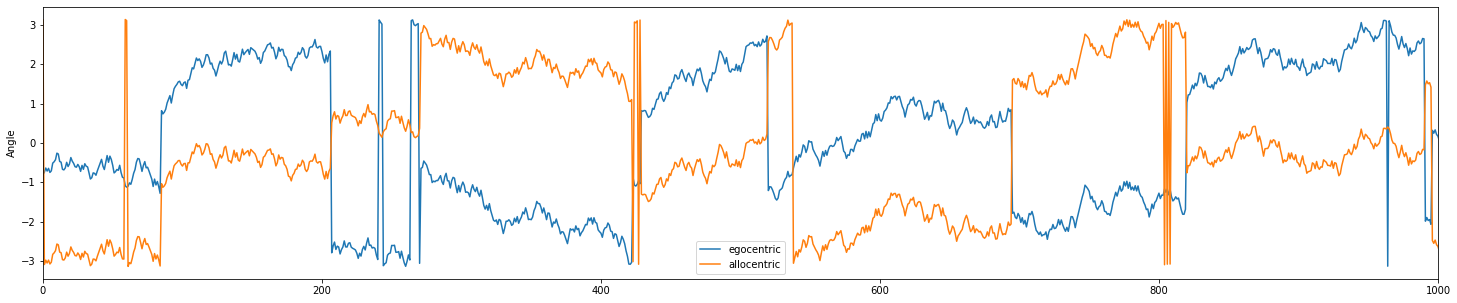

In [97]:
plt.plot(ego, label="egocentric")
plt.xlim(0,1000)
plt.plot(head_direction, label="allocentric")
plt.ylabel("Angle")
plt.legend()
plt.show()

## Egocentric bearing selectivity

The von Mises distribution is the equivalant of a Gaussian distribution for circular data.

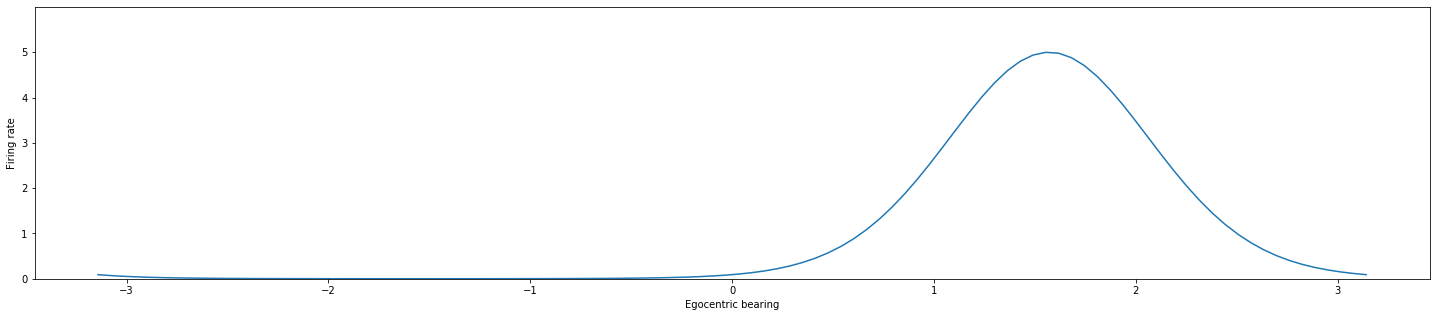

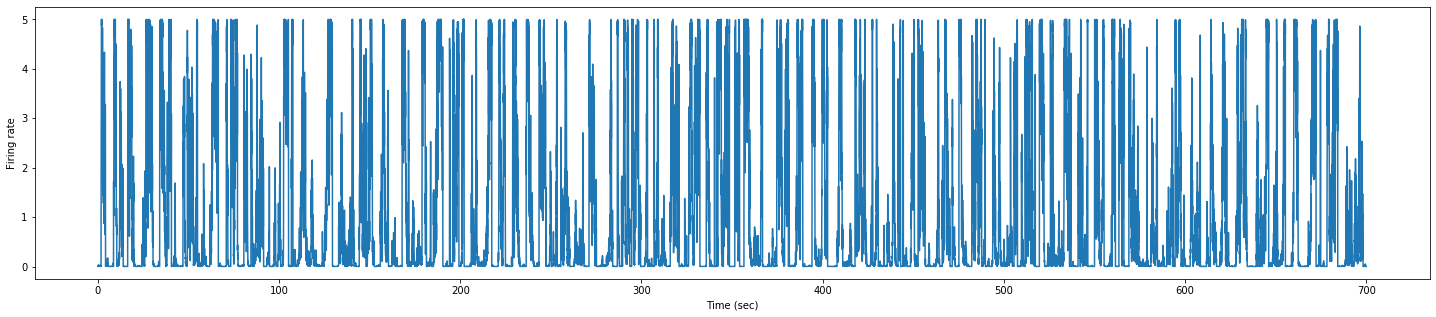

In [99]:
kappa=4
loc = np.pi/2
HpeakRateHz=5
x = np.linspace(-np.pi, np.pi, 100)

def vonmises_rate(x,loc,kappa,peakRateHz):
    """
    Get the rate for different angle x
    """
    maxDist=vonmises.pdf(loc,loc=loc,kappa=kappa)
    results = vonmises.pdf(x,kappa=kappa,loc=loc)
    return  results /maxDist*peakRateHz

y =vonmises_rate(x,loc,kappa,HpeakRateHz)
plt.plot(x, y)
plt.xlabel("Egocentric bearing")
plt.ylabel("Firing rate")
plt.ylim(0,y.max()+1)
plt.show()

E_rate = vonmises_rate(ego,loc,kappa,HpeakRateHz)
plt.plot(time, E_rate)
plt.xlabel("Time (sec)")
plt.ylabel("Firing rate")
plt.show()

## Simulate a spike train with the estimated rate

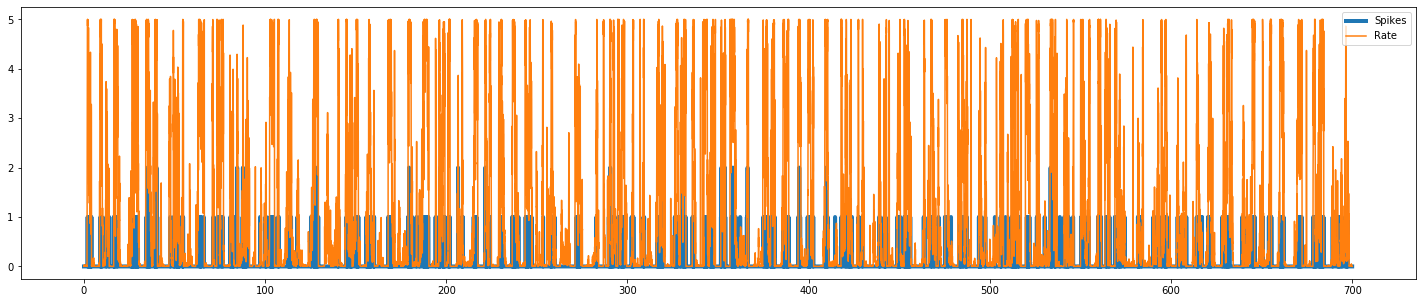

In [102]:
spikes = poisson.rvs(mu=E_rate*dt) # sample from a Poisson distribution. We pass the rate array to the function.
plt.plot(time,spikes,lw=4, label="Spikes")
plt.plot(time,E_rate, label="Rate")
plt.legend()
plt.show()

# Estimate the reference point given the spike train

We need to estimate what the reference point is given the spike train. This seems like an optimization problem.

We could evaluate the sqared difference of predicted and observed rate of the neuron.

Parameters to estimate:

* RefX
* RefY
* w (behavioral state parameters)


Steps in objective function:

1. Calculate the ego using parameters RefX, RefY
2. Calculate the rate given the ego and  parameters
3. Calculate the square difference of ifr data and ifr model


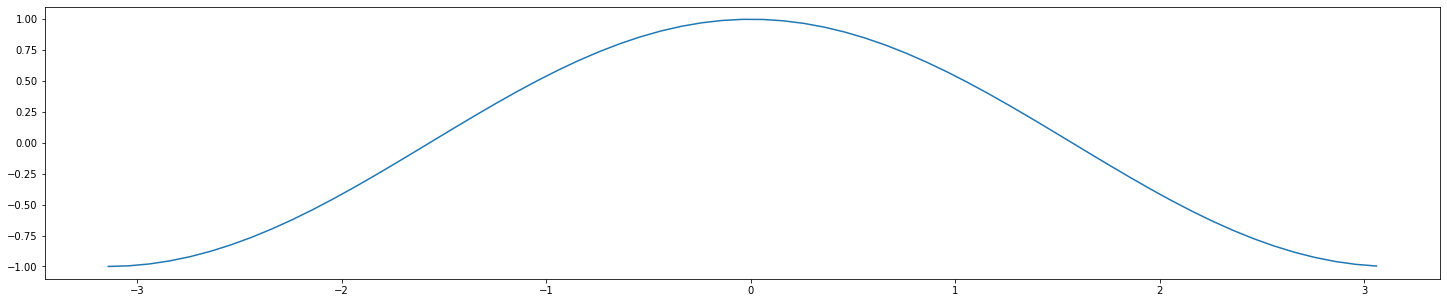

In [124]:
plt.plot(np.arange(-np.pi,np.pi,0.1),np.cos(np.arange(-np.pi,np.pi,0.10)))

In [120]:
%%time
degPerBin=np.pi*2/10

def objective_function(x0,spikes,list_Xt):
    """
    Function for which we want to find the minimum
    
    
    Returns 
    
    Negative log likelihood because our optimizer will look for the minimum
    """
    
    # set the parameters back to their array
    RefPoint = x0[0:2]
    w = x0[2:]
        
    position_x = list_Xt[0]
    position_y = list_Xt[1]
    head_direction = list_Xt[2]
    
    ego = np.empty(position_x.shape[0])
    
    print("Refpoint:",RefPoint)
    print("w:", w)
    
    
    # calculate the egocentric bearing angle to Ref point
    for i in range(ego.shape[0]):
        ego[i] = egocentric_direction_to_reference_point(animal_position = np.array([position_x[i],position_y[i]]), 
                                                         animal_hd = head_direction[i], reference_point = refPoint)
    
    # behavioral state 
    binIndices = ((ego+np.pi)/degPerBin).astype(int)
    Xt = np.zeros((int(2*np.pi/degPerBin),ego.shape[0]))
    for i in range(ego.shape[0]):
        Xt[binIndices[i],i]=+1
        
        
    # function to get the rate 
   
    r = np.exp(np.expand_dims(w,0)@Xt) # estimated rate
        
        
    l = np.sum(spikes * np.log(r) - r - np.log(factorial(spikes))) # log likelihood, high is more likely
    
    print("likelihood:",-l)
    return -l #+sm


## set all parameters in a 1D array
list_Xt = [position_x,position_y,head_direction]

# initialize learned parameters
x0= np.ones(12)


results = minimize(fun=objective_function,x0=x0,args=(spikes,list_Xt), options={"maxiter":20000,'disp':True})
print(results.message)

Refpoint: [1. 1.]
w: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
likelihood: 94467.11323403892
Refpoint: [1.00000001 1.        ]
w: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
likelihood: 94467.11323403892
Refpoint: [1.         1.00000001]
w: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
likelihood: 94467.11323403892
Refpoint: [1. 1.]
w: [1.00000001 1.         1.         1.         1.         1.
 1.         1.         1.         1.        ]
likelihood: 94467.11337671019
Refpoint: [1. 1.]
w: [1.         1.00000001 1.         1.         1.         1.
 1.         1.         1.         1.        ]
likelihood: 94467.11335217873
Refpoint: [1. 1.]
w: [1.         1.         1.00000001 1.         1.         1.
 1.         1.         1.         1.        ]
likelihood: 94467.11338974227
Refpoint: [1. 1.]
w: [1.         1.         1.         1.00000001 1.         1.
 1.         1.         1.         1.        ]
likelihood: 94467.11339163114
Refpoint: [1. 1.]
w: [1.         1.         1.         1.         1.00000001 1.
 1.         1. 

KeyboardInterrupt: 

In [108]:
print(results)

      fun: nan
 hess_inv: array([[1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 2.25254540e-04, 1.02561639e-02,
        1.29770350e-02],
       [0.00000000e+00, 0.00000000e+00, 1.02561639e-02, 5.36937472e-01,
        6.74660056e-01],
       [0.00000000e+00, 0.00000000e+00, 1.29770350e-02, 6.74660056e-01,
        8.55612764e-01]])
      jac: array([nan, nan, nan, nan, nan])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 696
      nit: 3
     njev: 116
   status: 2
  success: False
        x: array([    40.        ,     40.        ,   -336.03858717, -17556.70987087,
       -22239.63452648])
